In [250]:
# UT-TOR-DATA-PT-01-2020-U-C Week 10 Assignment
# SQLAlchemy Challenge
# Step 1: Climate Analysis and Exploration
# Bonus: Temperature Analysis I & II, Daily Rainfall Average
# (c) Boris Smirnov

In [251]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [252]:
import numpy as np
import pandas as pd

In [253]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [254]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc

In [255]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [256]:
# reflect an existing database into a new model
AutomapBase = automap_base()

# reflect the tables
AutomapBase.prepare(engine, reflect=True)

In [257]:
# We can view all of the classes that automap found
AutomapBase.classes.items()

[('measurement', sqlalchemy.ext.automap.measurement),
 ('station', sqlalchemy.ext.automap.station)]

In [258]:
# Save references to each table
Station = AutomapBase.classes.station
list(inspect(Station).columns)

[Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<station>),
 Column('name', TEXT(), table=<station>),
 Column('latitude', FLOAT(), table=<station>),
 Column('longitude', FLOAT(), table=<station>),
 Column('elevation', FLOAT(), table=<station>)]

In [259]:
Measurement = AutomapBase.classes.measurement
list(inspect(Measurement).columns)

[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

In [260]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Precipitation analysis


Design a query to retrieve the last 12 months of precipitation data and plot the results

In [261]:
# Calculate the date 1 year before the last data point in the database
last_date = session.query(func.max(Measurement.date)).scalar()
year_before = dt.date(*[int(d) for d in last_date.split('-')]) - dt.timedelta(days=365)
(last_date, year_before)

('2017-08-23', datetime.date(2016, 8, 23))

In [262]:
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_before).\
    order_by(Measurement.date) # Sort the dataframe by date
print(f"Total number of records returned for 1 last year of observations: {query.count()}")

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_data_df = pd.DataFrame(query)
precip_data_df.set_index('date', inplace=True)
precip_data_df.dropna(inplace=True)
print(f"Total number or precipitation records for 1 last year of observations: {len(precip_data_df)}")
precip_data_df.head(6)

Total number of records returned for 1 last year of observations: 2223
Total number or precipitation records for 1 last year of observations: 2015


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45


In [263]:
# There are several observations from different stations for each day
# Since it's a vacation we're talking about, I'll consider "worst case scenario"
# and use max daily precipitation volumes for plotting the chart
max_precip_df = precip_data_df.groupby(level=0).max()
max_precip_df.columns = ['Precipitation (in)']
print(f"Number of observed days: {len(max_precip_df)}")
max_precip_df.head(1)

Number of observed days: 365


,Precipitation (in)
date,
2016-08-24,2.28


<Figure size 432x288 with 0 Axes>

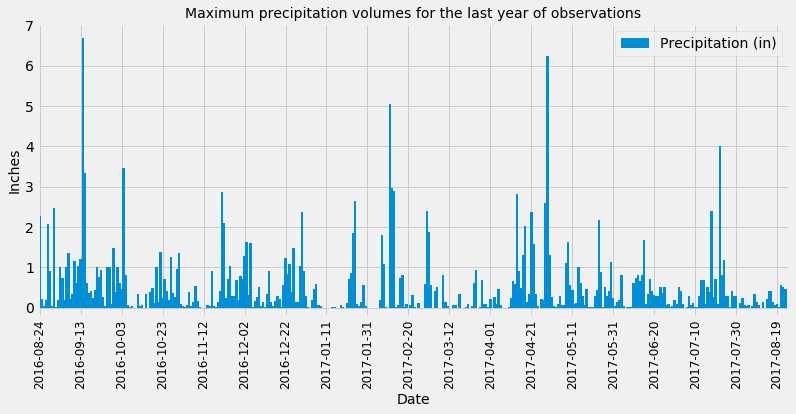

In [264]:
# Use Pandas Plotting with Matplotlib to plot the data
fig = plt.figure()

axes = max_precip_df.plot(kind='bar', figsize=(12, 5), width=1.2)

axes.set_title(
    'Maximum precipitation volumes for the last year of observations',
    fontdict={'fontsize': 14}
)

axes.set_xlabel('Date', fontdict={'fontsize': 14})
xticks = range(0, 365, 20)
axes.set_xticks(xticks)
axes.set_xticklabels([max_precip_df.index[i] for i in xticks], fontdict={'fontsize': 12})
axes.set_xlim(left=-1, right=366)

axes.set_ylabel('Inches', fontdict={'fontsize': 14})
axes.set_ylim(bottom=-0.2)

fig.tight_layout()
plt.show()

In [265]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_data_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [266]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Station).count()
print(f"Total number of stations in the dataset: {total_stations}")

Total number of stations in the dataset: 9


In [346]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_q = session.query(
    Measurement.station, Station.name, func.count(Measurement.station).label('measure counts')).\
    join(Station, Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(desc('measure counts'))

pd.DataFrame(stations_q)

,station,name,measure counts
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [347]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station_id = stations_q[0][0]

tobs_q = session.query(
        func.min(Measurement.tobs).label('Lowest Temperature'),
        func.max(Measurement.tobs).label('Highest Temperature'),
        func.round(func.avg(Measurement.tobs), 1).label('Average Temperature')
    ).filter_by(station=most_active_station_id)

pd.DataFrame(tobs_q)

,Lowest Temperature,Highest Temperature,Average Temperature
0,54.0,85.0,71.7


The station with the highest number of temperature observations: USC00519281


<Figure size 432x288 with 0 Axes>

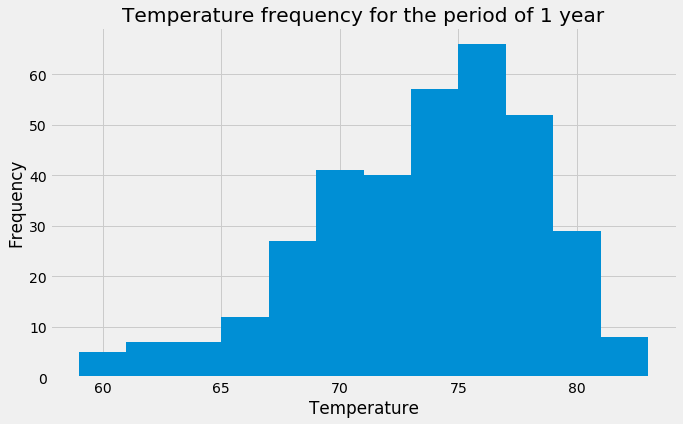

In [269]:
# Choose the station with the highest number of temperature observations.
tobs_best_station_id = session.query(Measurement.station, func.count(Measurement.tobs).label('tobs_count')).\
    group_by(Measurement.station).\
    order_by(desc('tobs_count')).\
    first()[0]

print(f"The station with the highest number of temperature observations: {tobs_best_station_id}")

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_q = session.query(Measurement.date, Measurement.tobs).\
    filter_by(station=tobs_best_station_id).\
    filter(Measurement.date > year_before)

tobs_df = pd.DataFrame(tobs_q)

fig = plt.figure()
axes = tobs_df.plot(
    kind='hist', bins=12, figsize=(10,6), legend=False,
    title='Temperature frequency for the period of 1 year',
)

axes.set_xlabel('Temperature')
fig.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [270]:
# Slightly modified: added rounding average, and made it return tuple, not a list of 1 tuple
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(
            func.min(Measurement.tobs),
            func.round(func.avg(Measurement.tobs), 1),
            func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).all()[0]

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

(62.0, 69.6, 74.0)


In [271]:
# This function called `past_period` will accept start date and end date in the format '%Y-%m-%d' 
# and return start date and end date for the same days of past year that has climate data in hawaii database
# Leap years are not accounted for, so the days will not be the same (1 day offset if after Feb 29, 2020)
def past_period(start_date, end_date):
    global last_date # previously retrieved last date in the database

    # validation
    assert end_date > start_date
    assert end_date > last_date

    # convertion
    last_d = dt.date(*[int(d) for d in last_date.split('-')])
    start_d = dt.date(*[int(d) for d in start_date.split('-')])
    end_d = dt.date(*[int(d) for d in end_date.split('-')])
    
    # calculation
    delta = end_d - last_d
    year_shift = delta.days // 365 
    day_shift = delta.days % 365
    if day_shift > 0:
        year_shift +=1
    delta = dt.timedelta(days = 365 * year_shift)

    return (start_d - delta).isoformat(), (end_d - delta).isoformat()

# function usage example
print(past_period('2020-02-28', '2020-03-12'))

('2017-02-28', '2017-03-13')


In [272]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
future_vacation = ('2020-07-27', '2020-08-05')
past_vacation = past_period(*future_vacation)
temps_stats = calc_temps(*past_vacation)
temps_stats

(72.0, 79.3, 84.0)

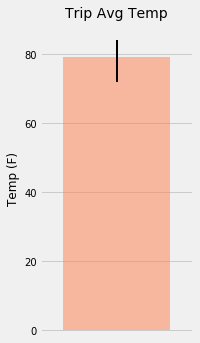

In [334]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig = plt.figure(figsize=(3, 5))
axes=  plt.subplot()
axes.bar([0.5], height=temps_stats[1], width=0.7, color='coral', alpha=0.5)
axes.errorbar(
    [0.5], temps_stats[1],
    yerr=[[temps_stats[1]-temps_stats[0]], [temps_stats[2]-temps_stats[1]]],
    ecolor='black', elinewidth=2)

axes.set_title('Trip Avg Temp', fontdict={'fontsize': 14})

axes.set_xlim(left=0.0, right=1.0)
axes.set_xticklabels([])

axes.set_yticks(range(0, 81, 20))
axes.set_ylabel('Temp (F)', fontdict={'fontsize': 12})
axes.set_ylim(bottom=-1, top=89)
plt.setp(axes.get_yticklabels(), fontsize=10)

axes.grid(axis='x', which='both')

fig.tight_layout()
plt.show()

In [348]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prcp_q = session.query(
        Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation,
        func.sum(Measurement.prcp).label('total_prcp')).\
    join(Station, Measurement.station == Station.station).\
    filter(Measurement.date >= past_vacation[0]).\
    filter(Measurement.date <= past_vacation[1]).\
    group_by(Measurement.station).\
    order_by(desc('total_prcp'))

pd.DataFrame(prcp_q)

,station,name,latitude,longitude,elevation,total_prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.31
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.38
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.38
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.19
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
5,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.01
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
